<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/main/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Group Number: 21   |                  |                |
| ----------- | ----------------------- | -------------- |
| Student 1   | N.P.G.T. van Beuningen  | 1353624        |
| Student 2   | D.P.M. van der Hoorn    | 1873334        |
| Student 3   | L.R. Siecker            | 1344838        |

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# Change the following  line to the directory this notebook is (if using colab)
# In case you do not know the path, open the file navigator on the left in colab
# Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


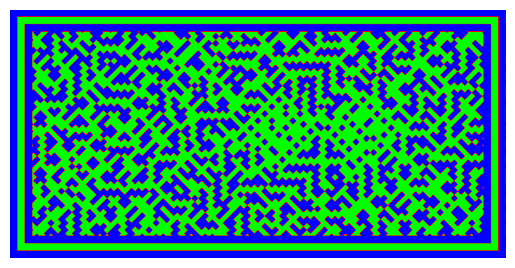

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
###     YOUR CODE FOR TASK 1    ###
'''
Na input meteen de slice layer

Pooling layer sws na de laatste convolutional layer en laatste spacing pooling layer, daarna kan
je de flatten layer doen en dan de fully connected layer (dense layer)
'''

class OriginPredictor(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            sc.Slice(4, False),

            sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            nn.Dropout2d(0.3),
            nn.ReLU(),

            sc.SymmetryPool(),

            nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(24, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



In [8]:
from torch.utils.data import DataLoader

# dataloader training
dataloader_training = DataLoader(dataset=train_dataset,
                                 batch_size=32,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=val_dataset,
                                   batch_size=32,
                                   shuffle=True)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

class PlotTraining():
    def __init__(self):
      self.train_accuracy = []
      self.train_loss = []
      self.evaluation_accuracy = []
      self.evaluation_loss = []
      self.test_accuracy = []
      self.test_loss = []

    def add_train(self, accuracy, loss):
      self.train_accuracy.append(accuracy)
      self.train_loss.append(loss)

    def add_evaluation(self, accuracy, loss):
      self.evaluation_accuracy.append(accuracy)
      self.evaluation_loss.append(loss)

    def add_test(self, accuracy, loss):
      self.test_accuracy.append(accuracy)
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      ax1.set_ylabel('accuracy')
      ax2 = ax1.twinx()
      ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_accuracy:
        ax1.plot(list(range(len(self.train_accuracy))), self.train_accuracy, label = "Training Accuracy", color=color[0])
      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_accuracy:
        ax1.plot(list(range(len(self.evaluation_accuracy))), self.evaluation_accuracy, label = "Evaluate Accuracy", color=color[2])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Evaluate Loss", color=color[3])
      if self.test_accuracy:
        ax1.plot(list(range(len(self.test_accuracy))), self.test_accuracy, label = "Test Accuracy", color=color[4])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()
      

In [10]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):
        plotter = PlotTraining()

        for epoch in tqdm(range(self.epochs)):
                 
            train_acc, val_acc = [], []

            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
                max_index_pred = torch.argmax(out_softmax, dim=1)
                max_index_test = torch.argmax(target, dim=1)

                pred_correct = torch.sum(max_index_pred == max_index_test)

                accuracy_value = 100*pred_correct.cpu().numpy()/len(out)
                train_acc.append(accuracy_value)
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                 
                    out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
                    max_index_pred = torch.argmax(out_softmax, dim=1)
                    max_index_test = torch.argmax(target, dim=1)

                    pred_correct = torch.sum(max_index_pred == max_index_test)

                    accuracy_value = 100*pred_correct.cpu().numpy()/len(out)
                    val_acc.append(accuracy_value)

                    loss_value = loss.item()
                    valid_losses.append(loss_value)

                  
                
            # print the results
            print(
                f' EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'TRAIN-ACC: {np.mean(train_acc):.2f}',end=' ')
            print(f'TRAIN-LOSS: {np.mean(train_losses):.4f}',end=' | ')
            print(f'VAL-ACC: {np.mean(val_acc):.2f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')
            plotter.add_train(np.mean(train_acc), np.mean(train_losses))
            plotter.add_evaluation(np.mean(val_acc), np.mean(valid_losses))
        plotter.plot()
   

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 5-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
 10%|█         | 1/10 [00:01<00:16,  1.87s/it]

 EPOCH: 01/10 TRAIN-ACC: 44.73 TRAIN-LOSS: 1.0346 | VAL-ACC: 68.80 VAL-LOSS: 0.8744


 20%|██        | 2/10 [00:03<00:14,  1.87s/it]

 EPOCH: 02/10 TRAIN-ACC: 75.85 TRAIN-LOSS: 0.7856 | VAL-ACC: 71.48 VAL-LOSS: 0.8333


 30%|███       | 3/10 [00:05<00:13,  1.86s/it]

 EPOCH: 03/10 TRAIN-ACC: 81.36 TRAIN-LOSS: 0.7278 | VAL-ACC: 81.80 VAL-LOSS: 0.7389


 40%|████      | 4/10 [00:07<00:10,  1.78s/it]

 EPOCH: 04/10 TRAIN-ACC: 83.95 TRAIN-LOSS: 0.7057 | VAL-ACC: 73.81 VAL-LOSS: 0.7897


 50%|█████     | 5/10 [00:08<00:08,  1.74s/it]

 EPOCH: 05/10 TRAIN-ACC: 85.72 TRAIN-LOSS: 0.6913 | VAL-ACC: 85.91 VAL-LOSS: 0.7004


 60%|██████    | 6/10 [00:10<00:07,  1.80s/it]

 EPOCH: 06/10 TRAIN-ACC: 85.42 TRAIN-LOSS: 0.6920 | VAL-ACC: 87.75 VAL-LOSS: 0.6768


 70%|███████   | 7/10 [00:12<00:05,  1.77s/it]

 EPOCH: 07/10 TRAIN-ACC: 88.67 TRAIN-LOSS: 0.6702 | VAL-ACC: 83.63 VAL-LOSS: 0.7336


 80%|████████  | 8/10 [00:14<00:03,  1.74s/it]

 EPOCH: 08/10 TRAIN-ACC: 90.56 TRAIN-LOSS: 0.6497 | VAL-ACC: 91.42 VAL-LOSS: 0.6540


 90%|█████████ | 9/10 [00:15<00:01,  1.75s/it]

 EPOCH: 09/10 TRAIN-ACC: 92.47 TRAIN-LOSS: 0.6336 | VAL-ACC: 95.29 VAL-LOSS: 0.6065


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

 EPOCH: 10/10 TRAIN-ACC: 93.54 TRAIN-LOSS: 0.6221 | VAL-ACC: 91.77 VAL-LOSS: 0.6258


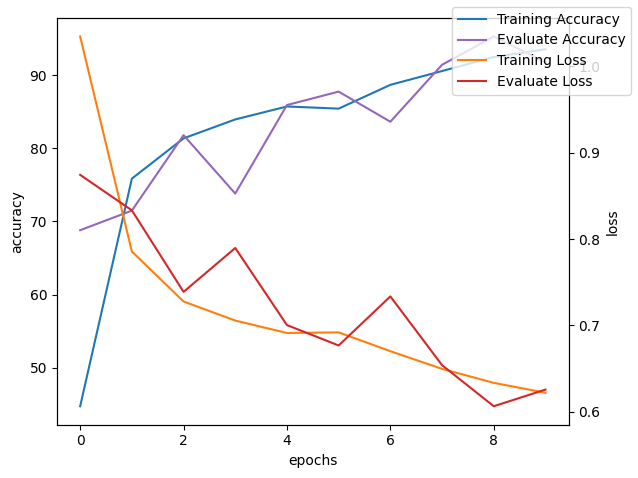

In [18]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')

originpred = OriginPredictor()

model = originpred.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.025)

trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  epochs=10)

trainer.run_trainer()

Carpet from Convolushahr is predicted as Convolushahr


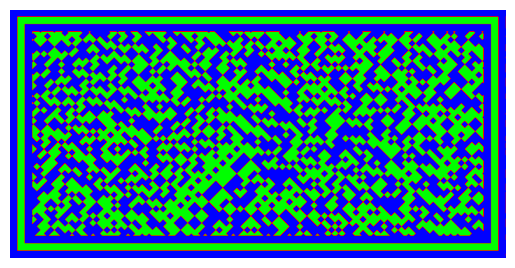

In [12]:
'''
(For the test dataset)
1. For each class a good classified carpet
2. For each class if possible a wrongly classified carpet
3. Accuracy of the model
'''


idx = np.random.randint(0,X_test.size(0))

model.eval()

with torch.no_grad():
    out = model(X_test[idx,None].to(device))  # send through model/network


out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index = torch.argmax(out_softmax, dim=1)

test_label = oh_to_label(y_test[idx,None])[0]

cls_dict = {0: 'Convolushahr', 1:'Transformabad', 2:'Reinforciya'}
pred_label = cls_dict[max_index.cpu().numpy()[0]]
show_carpet(X_test, idx)
print('Carpet from', test_label, 'is predicted as', pred_label)

In [13]:
model.eval()
with torch.no_grad():
    out = model(X_val.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model(X_test.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

Accuracy of the model on the validation set: 93.55%
Accuracy of the model on the test set: 92.6%


## Task 1: Question 5d

# Task 2: Carpet Matching 

In [14]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [15]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [16]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###